# GPT-4 API: Extract Structured Data from SEC Filings (Material Event Disclosures) and Analyze Stock Returns

Before starting, create a `.env` file in the root directory of the project and add the following environment variables:

```bash
OPENAI_API_KEY=your_openai_api_key
SEC_API_KEY=your_sec_api_key
```

## Structure

**Objective:** Analyze impact of non-reliance on previously issued financial statements disclosures on stock returns.


**Steps:**

1. [Learn about SEC Form 8-K filings and different types of disclosures.](./8K-background.ipynb)
1. Find and build a list of URLs of 8-K filings with Item 4.02 (Non-Reliance on Previously Issued Financial Statements).
1. Extract and download the Item 4.02 sections of the filings.
1. Use GPT-4 to extract structured data from the Item 4.02 sections.
1. Calculate 1-to-20 day returns after disclosure for each filing.
1. Descriptive statistics and return distributions for various subsets.
1. [Exercise] Enrich data with fundamental data and calculate returns based on financial metrics.

**Data sources:**
- [SEC-API.io](https://sec-api.io/)
  - [Query API](https://sec-api.io/docs/query-api) to find URLs of all 8-K filings with Item 4.02
  - [Extractor API](https://sec-api.io/docs/sec-filings-item-extraction-api) to extract and download Item 4.02 sections 
- AlgoSeek for historical stock prices
- [Exercise] [WRDS Compustat Daily Updates - Fundamentals Quarterly](https://wrds-www.wharton.upenn.edu/pages/get-data/) for fundamental data


More information about SEC Form 8-K filings and tutorials are available at [SEC-API.io](https://sec-api.io/resources/analyze-8-k-filings-and-material-event-disclosure-activity).

## Step 1: Locate URLs of 8-K filings with Item 4.02

In [29]:
# load OPENAI_API_KEY value from .env file
from dotenv import load_dotenv

load_dotenv()

True

In [30]:
!pip -q install sec-api

In [31]:
import os
from sec_api import QueryApi
import pandas as pd

SEC_API_KEY = os.getenv("SEC_API_KEY")

queryApi = QueryApi(api_key=SEC_API_KEY)

# Define search query to get 8-K filings with item 4.02 filed in 2022.
# In this example, we fetch the first 50 results.
payload = {
    # Search query written in Lucene syntax
    "query": 'formType:"8-K" AND items:"4.02" AND filedAt:[2022-01-01 TO 2022-12-31]',
    # Starting index of the results. Increment by 50 to get the next page of results.
    "from": "0", 
    # Number of results to return per API call
    "size": "50", 
     # Sort by filedAt in descending order
    "sort": [{"filedAt": {"order": "desc"}}],
}

# Format of response is explained at 
# https://sec-api.io/docs/query-api#response-format
response = queryApi.get_filings(payload)

# Convert JSON array to DataFrame
metadata_sample = pd.DataFrame(response["filings"])

columns_of_interest = [
    "formType", # EDGAR form type
    "filedAt", # Date the filing was accepted by the EDGAR system
    "accessionNo", # Unique identifier for the filing
    "ticker", # Stock ticker
    "cik", # Central Index Key: unique identifier for a company
    "companyName", # Name of the company
    "items", # List of items in the filing
    "linkToFilingDetails",  # URL to the filing
]

print(f"Number of filings: {metadata_sample.shape[0]}")
metadata_sample[columns_of_interest].head(5)

Number of filings: 50


,formType,filedAt,accessionNo,ticker,cik,companyName,items,linkToFilingDetails
0,8-K,2022-12-27T16:20:13-05:00,0001213900-22-082892,POLCQ,1810140,Polished.com Inc.,[Item 4.01: Changes in Registrant's Certifying...,https://www.sec.gov/Archives/edgar/data/181014...
1,8-K,2022-12-22T16:30:53-05:00,0001493152-22-036320,GLLI,1888734,GLOBALINK INVESTMENT INC.,[Item 4.02: Non-Reliance on Previously Issued ...,https://www.sec.gov/Archives/edgar/data/188873...
2,8-K,2022-12-21T17:25:38-05:00,0001213900-22-081850,CLRC,1903392,ClimateRock,[Item 4.02: Non-Reliance on Previously Issued ...,https://www.sec.gov/Archives/edgar/data/190339...
3,8-K,2022-12-16T16:17:36-05:00,0001185185-22-001426,FEIM,39020,FREQUENCY ELECTRONICS INC,[Item 2.02: Results of Operations and Financia...,https://www.sec.gov/Archives/edgar/data/39020/...
4,8-K,2022-12-16T16:05:27-05:00,0001493152-22-035733,VTRO,793171,"Vitro Biopharma, Inc.",[Item 4.02: Non-Reliance on Previously Issued ...,https://www.sec.gov/Archives/edgar/data/793171...


In [32]:
# Get first 50 filings of each month in 2022 (for demonstration purposes only)
# In practice, you would want to get all filings for the year (or a longer period of time)
def get_filings_metadata(year=2022):
    metadata_list = []

    for month in range(1, 13):
        # Iterate over "from" in 50 increments to get all filings for the year
        # for i in range(0, 10000, 50): # Uncomment to get all filings for the year
        for i in range(
            0, 50, 50
        ):  # For demonstration purposes, only get first 50 filings of each month
            start_date = f"{year}-{month:02d}-01"
            end_date = f"{year}-{month:02d}-31"
            query = f'formType:"8-K" AND items:"4.02" AND filedAt:[{start_date} TO {end_date}]'
            payload = {
                "query": query,
                "from": i,
                "size": "50",
                "sort": [{"filedAt": {"order": "desc"}}],
            }
            response = queryApi.get_filings(payload)
            if len(response["filings"]) == 0:
                break
            metadata_list.append(response["filings"])

        print(f"✅ Month {month:02d} completed")

    # Flatten the list of lists: [[1, 2], [3, 4]] -> [1, 2, 3, 4]
    metadata_list = [item for sublist in metadata_list for item in sublist]
    # Convert JSON array to DataFrame
    metadata_df = pd.DataFrame(metadata_list)
    # Drop duplicates
    metadata_df = metadata_df.drop_duplicates(subset=["accessionNo"])

    print(f"✅ Done. Total filings: {len(metadata_list)}")

    return metadata_df[
        [
            "formType",
            "filedAt",
            "accessionNo",
            "ticker",
            "cik",
            "companyName",
            "items",
            "linkToFilingDetails",
        ]
    ]

In [33]:
metadata_2022 = get_filings_metadata(2022)

✅ Month 01 completed
✅ Month 02 completed
✅ Month 03 completed
✅ Month 04 completed
✅ Month 05 completed
✅ Month 06 completed
✅ Month 07 completed
✅ Month 08 completed
✅ Month 09 completed
✅ Month 10 completed
✅ Month 11 completed
✅ Month 12 completed
✅ Done. Total filings: 305


In [34]:
metadata_2022.head(5)

,formType,filedAt,accessionNo,ticker,cik,companyName,items,linkToFilingDetails
0,8-K,2022-01-31T21:35:24-05:00,0001829126-22-002268,,1740742,"TransparentBusiness, Inc.",[Item 4.01: Changes in Registrant's Certifying...,https://www.sec.gov/Archives/edgar/data/174074...
1,8-K,2022-01-31T08:50:59-05:00,0001104659-22-009285,OEPW,1824677,One Equity Partners Open Water I Corp.,[Item 4.02: Non-Reliance on Previously Issued ...,https://www.sec.gov/Archives/edgar/data/182467...
2,8-K,2022-01-31T07:03:59-05:00,0001564590-22-003120,BIOCQ,1044378,BIOCEPT INC,[Item 4.02: Non-Reliance on Previously Issued ...,https://www.sec.gov/Archives/edgar/data/104437...
3,8-K,2022-01-28T17:40:28-05:00,0001213900-22-004297,SCAQ,1821812,Stratim Cloud Acquisition Corp.,[Item 4.02: Non-Reliance on Previously Issued ...,https://www.sec.gov/Archives/edgar/data/182181...
4,8-K,2022-01-28T17:02:06-05:00,0001193125-22-021724,DTRT,1865537,DTRT Health Acquisition Corp.,[Item 4.02: Non-Reliance on Previously Issued ...,https://www.sec.gov/Archives/edgar/data/186553...


In [7]:
# Save the DataFrame to a CSV file ./data/edgar/8K-filing-metadata.csv
metadata_2022.to_csv("./data/edgar/8K-filing-metadata.csv", index=False)

## Step 2: Download Item 4.02 sections

We use the [Extractor API](https://sec-api.io/docs/sec-filings-item-extraction-api) to extract and download the Item 4.02 sections of the filings and save them as text files. `pandarallel` is used to parallelize downloading of Item 4.02 sections and speed up the process.

In [35]:
from sec_api import ExtractorApi
import time

extractorApi = ExtractorApi(SEC_API_KEY)


def extract_section_4_02_and_save_to_file(df_row, retry_count=0):
    cik = df_row["cik"]
    accessionNo = df_row["accessionNo"]
    filingUrl = df_row["linkToFilingDetails"]
    itemId = "4-2"

    try:
        # Check if output directory exists, if not create it
        output_dir = f"./data/edgar/8K-item-4.02/{cik}"
        os.makedirs(output_dir, exist_ok=True)
        # Save extracted text to a file ./data/edgar/{cik}/{accessionNo}-item-{itemId}.txt
        file_name = f"{accessionNo}-item-{itemId}.txt"
        file_path = os.path.join(output_dir, file_name)
        # Skip if the file already exists
        if os.path.exists(file_path):
            return
        # Extract the text of the section with itemId and save it to a file
        section_content = extractorApi.get_section(filingUrl, itemId, "text")
        with open(file_path, "w") as f:
            f.write(section_content)

    except Exception as e:
        # If e contains 429, retry the request after waiting for
        # 300 milliseconds to the power of retry_count
        if "429" in str(e) and retry_count < 3:
            print(f"Retrying for CIK {cik} at {filingUrl}")
            time.sleep(0.3 ** (retry_count + 1))
            return extract_section_4_02_and_save_to_file(df_row, retry_count + 1)
        else:
            print(f"Failed to extract item {itemId} for CIK {cik} at {filingUrl}")
            print(e)

In [36]:
# Test the function with a single row
single = metadata_2022.iloc[0]
extract_section_4_02_and_save_to_file(single)

In [37]:
!pip -q install pandarallel ipywidgets

In [38]:
from pandarallel import pandarallel

number_of_parallel_downloads = 10

pandarallel.initialize(
    progress_bar=True, nb_workers=number_of_parallel_downloads, verbose=1
)

metadata_2022.parallel_apply(extract_section_4_02_and_save_to_file, axis=1)

print("✅ All sections extracted and saved to files")

✅ All sections extracted and saved to files


## Step 3: Use GPT-4 API to extract structured data from Item 4.02 sections

We use the [Chat Completion API](https://platform.openai.com/docs/guides/text-generation/chat-completions-api) and GPT-4 to extract structured data from the Item 4.02 sections.

In [39]:
from IPython.display import display, HTML

# Load an extracted section from a sample filing
sample_filing = metadata_2022.iloc[0]
cik = sample_filing["cik"]
accessionNo = sample_filing["accessionNo"]
filingUrl = sample_filing["linkToFilingDetails"]
file_name = f"{accessionNo}-item-4-2.txt"
file_path = f"./data/edgar/8K-item-4.02/{cik}/{file_name}"

with open(file_path, "r") as f:
    sample_section = f.read()

print(f"📄 Sample section from {filingUrl}")
display(HTML(sample_section))

📄 Sample section from https://www.sec.gov/Archives/edgar/data/1740742/000182912622002268/transparentbusiness_8k.htm


In [40]:
from openai import OpenAI

openai_client = OpenAI()

prompt = f"""Task: Given the following 8-K filing section 4.02, extract the key components of the disclosure, the identified issue (or issues), affected reporting periods, whether a restatement is neccesary or not, the reasons for a restatement, the impact of the error, whether the impact is material or not, the company's auditor, and the event classiciation. Return the extracted structured data as a JSON object. Only respond with the JSON object, and do not respond with anything else.

Structure of JSON object:
'''
{{
  "keyComponents": "...", // string: key components of the disclosure
  "identifiedIssue": ["..."], // array of strings: identified issue (or issues)
  "affectedReportingPeriods": ["..."], // array of strings: affected reporting periods in format "Q1 2023", "Q2 2023", etc. or "FY 2023"
  "restatementIsNecessary": true|false, // boolean: whether a restatement is necessary or not
  "reasonsForRestatement": ["..."], // array of strings: reasons for a restatement
  "impactOfError": "...", // string: impact of the error
  "impactIsMaterial": true|false, // boolean: whether the impact is material or not
  "auditors": ["..."], // array of string: company's auditor or auditors. If no auditor is mentioned, return an empty array. If multiple auditors are mentioned, return an array with all auditors.
  "eventClassification": "..." // string: event classification, such as "Financial Restatement Due to Revenue Recognition Errors"
}}
'''

Input text:
'''
{sample_section}
'''

Response:
"""

response = openai_client.chat.completions.create(
    model="gpt-4-turbo",
    messages=[{"role": "user", "content": prompt}],
)

In [41]:
response_string = response.choices[0].message.content
print(response_string)

```json
{
  "keyComponents": "Non-reliance on previously issued financial statements, consultation with technical accountants and auditors, identification of material errors, need for restatement of financial statements, and caution against reliance on certain prior communications.",
  "identifiedIssue": [
    "Errors related to accounting for deferred tax liabilities",
    "Incorrect netting of deferred tax liabilities against deferred tax assets due to non-consolidated tax filing status"
  ],
  "affectedReportingPeriods": [
    "FY 2020"
  ],
  "restatementIsNecessary": true,
  "reasonsForRestatement": [
    "Material error in accounting for deferred tax liabilities",
    "Incorrect accounting treatment of taxes after acquisition"
  ],
  "impactOfError": "Understated deferred tax liabilities and Goodwill by $969,940 as of December 31, 2020",
  "impactIsMaterial": true,
  "auditors": [
    "Former Auditor",
    "Paris Kreit & Chiu"
  ],
  "eventClassification": "Financial Restatement 

In [43]:
import json

# Remove starting "```json" and ending "```" values from GPTs response
response_string = response_string.replace("```json\n", "").replace("```", "").replace("\n", "")
# Convert to JSON object
extracted_data_json = json.loads(response_string)
extracted_data_json

{'keyComponents': 'Non-reliance on previously issued financial statements, consultation with technical accountants and auditors, identification of material errors, need for restatement of financial statements, and caution against reliance on certain prior communications.',
 'identifiedIssue': ['Errors related to accounting for deferred tax liabilities',
  'Incorrect netting of deferred tax liabilities against deferred tax assets due to non-consolidated tax filing status'],
 'affectedReportingPeriods': ['FY 2020'],
 'restatementIsNecessary': True,
 'reasonsForRestatement': ['Material error in accounting for deferred tax liabilities',
  'Incorrect accounting treatment of taxes after acquisition'],
 'impactOfError': 'Understated deferred tax liabilities and Goodwill by $969,940 as of December 31, 2020',
 'impactIsMaterial': True,
 'auditors': ['Former Auditor', 'Paris Kreit & Chiu'],
 'eventClassification': 'Financial Restatement Due to Errors in Tax Accounting'}

In [44]:
print("✅ Extracted data from the 8-K filing section 4.02")
print("Event classification:", extracted_data_json["eventClassification"])
print("Impact of the error:", extracted_data_json["impactOfError"])

✅ Extracted data from the 8-K filing section 4.02
Event classification: Financial Restatement Due to Errors in Tax Accounting
Impact of the error: Understated deferred tax liabilities and Goodwill by $969,940 as of December 31, 2020


In [45]:
# Load the extracted structured data into a DataFrame
structured_data_sample = pd.json_normalize(extracted_data_json)
structured_data_sample

,keyComponents,identifiedIssue,affectedReportingPeriods,restatementIsNecessary,reasonsForRestatement,impactOfError,impactIsMaterial,auditors,eventClassification
0,Non-reliance on previously issued financial st...,[Errors related to accounting for deferred tax...,[FY 2020],True,[Material error in accounting for deferred tax...,Understated deferred tax liabilities and Goodw...,True,"[Former Auditor, Paris Kreit & Chiu]",Financial Restatement Due to Errors in Tax Acc...


In [47]:
# To speed up things, I prepared a CSV file with the extracted structured data
# for all 8-K filings in 2022 with Item 4.02. Let's load it into a DataFrame.
structured_data_2022 = pd.read_csv(
    "./data/edgar/8K-4.02-structured-data-and-metadata-2022.csv",
    parse_dates=["filedAt"],
    # Convert the following columns to lists
    converters={
        "identifiedIssue": eval,
        "affectedReportingPeriods": eval,
        "reasonsForRestatement": eval,
        "auditors": eval,
    },
)
print(f"Number of filings: {structured_data_2022.shape[0]}")
structured_data_2022.head()

Number of filings: 284


,keyComponents,identifiedIssue,affectedReportingPeriods,restatementIsNecessary,reasonsForRestatement,impactOfError,impactIsMaterial,auditors,eventClassification,cik,accessionNo,ticker,filedAt
0,Identification of errors in financial statemen...,[Misclassification of certain expenses and rec...,"[Q1 2022, FY 2021]",True,[To correct classification of certain expenses...,Material weakness in design and operation of e...,True,[Ernst & Young LLP],Financial Restatement Due to Misclassification...,1005286,0001005286-22-000049,LFCR,2022-09-13 21:45:06-04:00
1,"The Board of Intellicheck, Inc. has determined...",[Misclassification of certain option awards as...,"[Q3 2020, Q1 2021, Q2 2021, Q3 2021, FY 2020, ...",True,"[Change in classification of option awards, Ad...",The errors are expected to increase accrued li...,True,[Independent Registered Public Accounting Firm],Financial Restatement Due to Misclassification...,1040896,0001493152-22-014655,IDN,2022-05-20 17:26:31-04:00
2,Non-Reliance on Previously Issued Financial St...,[Failure to accrue for certain expenses incurred],[Q3 2021],True,[Failure to accrue for expenses estimated betw...,Underreported expenses by approximately $1.0 t...,True,[Mayer Hoffman McCann P.C.],Financial Restatement Due to Expense Recogniti...,1044378,0001564590-22-003120,BIOCQ,2022-01-31 07:03:59-05:00
3,Identification of an accounting error in previ...,[Error in the application of Accounting Standa...,"[Q1 2022, Q2 2022]",True,[To correct misstatements in financial stateme...,Overstatement of both fleet new vehicle revenu...,True,[KPMG LLP],Financial Restatement Due to Revenue Recogniti...,1043509,0001043509-22-000016,SAH,2022-10-28 17:00:49-04:00
4,Non-Reliance on Previously Issued Financial St...,[Financial records of Human Brands were defici...,[Q2 2021],True,[Deficiencies in the financial records of Huma...,Non-compliance with Regulation S-X requirement...,True,[B.F Borgers C.P.A.],Financial Restatement Due to Non-Compliance wi...,1058330,0001903596-22-000275,ROAG,2022-05-10 16:53:49-04:00


### Auditors involved in material financial restatements

In [53]:
# Quick look at auditors involved in material restatements
auditors = (
    structured_data_2022[
        structured_data_2022["restatementIsNecessary"]
        & structured_data_2022["impactIsMaterial"]
    ]["auditors"]
    .explode()
    .fillna("NaN")
)

# Remove "Independent registered public accounting firm", "Not specified" and others from list
auditors = auditors[
    ~auditors.isin(
        [
            "Independent registered public accounting firm",
            "Not specified",
            "Not explicitly mentioned",
            "Independent accountant",
            "NaN",
        ]
    )
    # Or if auditor name includes phrase "independent registered public"
    & ~auditors.str.contains("independent registered public", case=False)
    & ~auditors.str.contains("Not explicitly mentioned", case=False)
].reset_index(drop=True)

# Standardize names of auditors to cover slight variations. 
# In practice, you may need to add more complex rules to cover all variations.
# Example: "WithumSmith+Brown, PC" vs "WithumSmith+Brown, P.C."
auditors = auditors.str.replace(r".", "")

# Count the number of times each auditor appears
auditors_count = auditors.value_counts().to_frame().reset_index()
auditors_count["pct"] = auditors_count["count"] / auditors_count["count"].sum() * 100
auditors_count["pct"] = auditors_count["pct"].round(1)

print("🔍 Top 10 auditors involved in material restatements in 2022:")
auditors_count.head(10)

🔍 Top 10 auditors involved in material restatements in 2022:


,auditors,count,pct
0,"WithumSmith+Brown, PC",46,19.9
1,Marcum LLP,35,15.2
2,"BDO USA, LLP",18,7.8
3,Ernst & Young LLP,13,5.6
4,PricewaterhouseCoopers LLP,8,3.5
5,Friedman LLP,6,2.6
6,KPMG LLP,6,2.6
7,RSM US LLP,5,2.2
8,UHY LLP,5,2.2
9,Moss Adams LLP,3,1.3


## Step 4: Calculate 1-20-day post disclosure returns

We use historical daily stock prices from AlgoSeek for 2022 to calculate the 1 to 20 day returns after the disclosure date for each filing. In practice, you would use a larger dataset and more filings, such as all filings with Item 4.02 in the last 10 years. Otherwise, the sample size is too small to draw meaningful, statistically significant conclusions.

In [57]:
stock_prices_2022_8K = pd.read_csv(
    "./data/historical-prices/daily-price-vol-8K-4.02-2022.csv", parse_dates=["Date"]
)

# Add missing dates (e.g. weekends, holidays) for each ticker and forward fill the missing values
stock_prices_2022_8K = (
    stock_prices_2022_8K.groupby("Ticker")
    .apply(lambda x: x.set_index("Date").asfreq("D", method="ffill"))
    .drop(columns=["Ticker"])
    .reset_index()
)

stock_prices_2022_8K.head(10)

/var/folders/q3/bt7922t52p78qdm75h_8m5yh0000gn/T/ipykernel_19558/3289851412.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.set_index("Date").asfreq("D", method="ffill"))


,Ticker,Date,Open,High,Low,Close,Volume,OpenAdjusted,HighAdjusted,LowAdjusted,CloseAdjusted,VolumeAdjusted
0,AACI,2022-01-03,9.8150,9.9100,9.8100,9.884,112300.0,9.8150,9.9100,9.8100,9.884,112300.0
1,AACI,2022-01-04,9.9000,9.9200,9.8600,9.910,1799.0,9.9000,9.9200,9.8600,9.910,1799.0
2,AACI,2022-01-05,9.8824,9.8854,9.8000,9.800,7.0,9.8824,9.8854,9.8000,9.800,7.0
3,AACI,2022-01-06,9.8200,9.8400,9.8000,9.800,447937.0,9.8200,9.8400,9.8000,9.800,447937.0
4,AACI,2022-01-07,9.8900,9.9140,9.8000,9.870,970.0,9.8900,9.9140,9.8000,9.870,970.0
5,AACI,2022-01-08,9.8900,9.9140,9.8000,9.870,970.0,9.8900,9.9140,9.8000,9.870,970.0
6,AACI,2022-01-09,9.8900,9.9140,9.8000,9.870,970.0,9.8900,9.9140,9.8000,9.870,970.0
7,AACI,2022-01-10,9.8400,9.8900,9.8400,9.865,8345.0,9.8400,9.8900,9.8400,9.865,8345.0
8,AACI,2022-01-11,9.8699,9.8700,9.8500,9.870,768.0,9.8699,9.8700,9.8500,9.870,768.0
9,AACI,2022-01-12,9.8600,9.8600,9.8518,9.860,31.0,9.8600,9.8600,9.8518,9.860,31.0


In [58]:
# Create a dict with "TICKER-DATE" as key and "CloseAdjusted" as value
stock_prices_2022_8K["Ticker-Date"] = stock_prices_2022_8K["Ticker"] + "-" + stock_prices_2022_8K["Date"].dt.strftime("%Y-%m-%d")
stock_prices_2022_8K_dict = stock_prices_2022_8K.set_index("Ticker-Date")["CloseAdjusted"].to_dict()

print(f"Tickers loaded: {len(stock_prices_2022_8K['Ticker'].unique())}")
# Show first 10 items in the dictionary
dict(list(stock_prices_2022_8K_dict.items())[:10])

Tickers loaded: 122


{'AACI-2022-01-03': 9.884,
 'AACI-2022-01-04': 9.91,
 'AACI-2022-01-05': 9.8,
 'AACI-2022-01-06': 9.8,
 'AACI-2022-01-07': 9.87,
 'AACI-2022-01-08': 9.87,
 'AACI-2022-01-09': 9.87,
 'AACI-2022-01-10': 9.865,
 'AACI-2022-01-11': 9.87,
 'AACI-2022-01-12': 9.86}

In [59]:
# For each row in structured_data_2022, get the closing price for the ticker on the filing date,
# the next 1/2/3/5/10/20 trading days, and calculate the percentage change in price
# between the filing date and the future date(s), and add 1dReturn, 2dReturn, 3dReturn, 5dReturn, 10dReturn, 20dReturn columns
# to structured_data_2022

# Calculate 1/2/3/5/10/20 day returns
def get_price_changes(ticker, date):
    price_changes = {}
    day0AdjClosePrice = stock_prices_2022_8K_dict.get(
        f"{ticker}-{date.strftime('%Y-%m-%d')}"
    )

    for days in [1, 2, 3, 5, 10, 20]:
        future_date = date + pd.Timedelta(days=days)
        future_date_str = future_date.strftime("%Y-%m-%d")
        future_date_key = f"{ticker}-{future_date_str}"
        if future_date_key in stock_prices_2022_8K_dict:
            dayXAdjClosePrice = stock_prices_2022_8K_dict[future_date_key]
            price_changes[f"{days}dReturn"] = round(
                (dayXAdjClosePrice / day0AdjClosePrice - 1) * 100, 2
            )
        else:
            price_changes[f"{days}dReturn"] = None

    return price_changes


structured_data_2022["priceChanges"] = structured_data_2022.apply(
    lambda x: get_price_changes(x["ticker"], x["filedAt"]), axis=1
)

# Explode priceChanges dicts to separate columns
price_changes_df = pd.json_normalize(structured_data_2022["priceChanges"])

# Check if column "1dReturn" does not exist in structured_data_2022
# allowing for re-running the cell without adding duplicate columns
if "1dReturn" not in structured_data_2022.columns:
    structured_data_2022 = (
        pd.concat([structured_data_2022, price_changes_df], axis=1)
        .dropna(subset=["1dReturn"])
        .reset_index(drop=True)
    )

structured_data_2022.drop(columns=["priceChanges"], inplace=True)

print("✅ Calculated 1/2/3/5/10/20 day returns for each filing")
structured_data_2022.head()

✅ Calculated 1/2/3/5/10/20 day returns for each filing


,keyComponents,identifiedIssue,affectedReportingPeriods,restatementIsNecessary,reasonsForRestatement,impactOfError,impactIsMaterial,auditors,eventClassification,cik,accessionNo,ticker,filedAt,1dReturn,2dReturn,3dReturn,5dReturn,10dReturn,20dReturn
0,Identification of an accounting error in previ...,[Error in the application of Accounting Standa...,"[Q1 2022, Q2 2022]",True,[To correct misstatements in financial stateme...,Overstatement of both fleet new vehicle revenu...,True,[KPMG LLP],Financial Restatement Due to Revenue Recogniti...,1043509,0001043509-22-000016,SAH,2022-10-28 17:00:49-04:00,0.00,0.00,-1.14,-3.89,-0.95,8.49
1,Non-Reliance on Previously Issued Financial St...,[Improper revenue recognition presentation as ...,"[FY 2021, Q3 2022]",True,[SEC's objection to revenue presentation on a ...,Change in presentation of service revenue from...,False,"[Baker Tilly US, LLP]",Financial Restatement Due to Revenue Recogniti...,1013706,0001171843-22-007863,WHLM,2022-12-06 16:25:39-05:00,1.48,-2.96,-3.23,-3.23,-4.31,-4.31
2,Accounting irregularities in the Pipeline Engi...,[Accounting irregularities in the financial st...,"[FY 2018, FY 2019, FY 2020, Q1 2020, Q2 2020, ...",True,[Certain misstatements contained in the consol...,Certain misstatements in the consolidated fina...,True,"[Ernst & Young LLP, PricewaterhouseCoopers LLP]",Financial Restatement Due to Revenue Recogniti...,1091883,0001091883-22-000012,CIR,2022-03-14 16:16:21-04:00,17.28,19.11,22.47,23.62,16.68,14.09
3,Non-Reliance on Previously Issued Financial St...,[Errors in the timing of recognition of the Co...,"[FY 2021, Q1 2021, Q2 2021, Q3 2021, Q4 2021, ...",True,[Discrepancies detected between estimated accr...,"Understatement of Reported Revenues, Operating...",True,"[Moss Adams LLP, BDO USA, LLP]",Financial Restatement Due to Revenue Recogniti...,1171155,0000950170-22-019267,RLGT,2022-10-04 16:06:07-04:00,-0.83,-2.64,-8.43,-8.43,-7.77,-2.98
4,Non-Reliance on Previously Issued Financial St...,[Error in accounting for net unrealized losses...,"[Q1 2022, Q2 2022]",True,[Incorrect classification of net unrealized lo...,Net unrealized losses were incorrectly recorde...,True,[Ernst & Young LLP],Financial Restatement Due to Revenue Recogniti...,1172222,0001172222-22-000081,HA,2022-10-24 06:05:55-04:00,-0.29,-8.01,-9.32,-6.57,-11.02,-2.26


## Step 5: Analyze and visualize data

In [60]:
# For xdReturn columns, calculate descriptive statistics
price_return_columns = ["1dReturn", "2dReturn", "3dReturn", "5dReturn", "10dReturn", "20dReturn"]

price_return_stats = structured_data_2022[price_return_columns].describe().T.round(2)

print("📈 Price return statistics following non-reliance disclosures in 2022:")
price_return_stats

📈 Price return statistics following non-reliance disclosures in 2022:


,count,mean,std,min,25%,50%,75%,max
1dReturn,127.0,0.16,6.77,-40.51,-0.10,0.00,0.10,42.38
2dReturn,127.0,-0.02,8.78,-41.41,-0.10,0.00,0.10,61.90
3dReturn,127.0,-0.50,8.59,-47.11,-0.12,0.00,0.20,43.33
5dReturn,127.0,-1.08,9.50,-47.11,-0.29,0.00,0.20,40.00
10dReturn,125.0,-1.62,12.21,-47.11,-0.41,0.05,0.21,65.24
20dReturn,123.0,-2.99,11.97,-59.20,-0.77,0.10,0.30,31.38


In [24]:
!pip -q install matplotlib

In [25]:
import matplotlib.pyplot as plt
import matplotlib.style as style

style.use("default")

params = {
    "axes.labelsize": 8,
    "font.size": 8,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "text.usetex": False,
    "font.family": "sans-serif",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "grid.color": "grey",
    "axes.grid": True,
    "axes.grid.axis": "y",
    "grid.alpha": 0.5,
    "grid.linestyle": ":",
}

plt.rcParams.update(params)

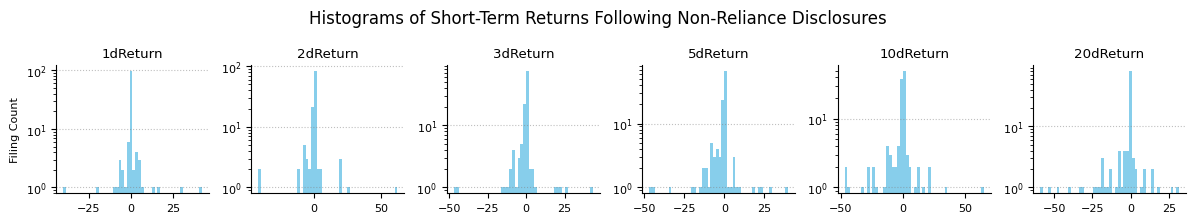

In [61]:
def plot_histograms(returns):
    width = 2 * len(returns.columns)
    plots = len(returns.columns)
    fig, axes = plt.subplots(1, plots, figsize=(width, 2.2))

    for i, ax in enumerate(axes.flatten()):
        if i == 0:
            ax.set_ylabel("Filing Count")
        column = returns.columns[i]
        data_to_plot = returns[column].dropna()
        ax.hist(data_to_plot, bins=50, color="skyblue")
        ax.set_title(column)
        ax.set_yscale("log")

    plt.suptitle("Histograms of Short-Term Returns Following Non-Reliance Disclosures", fontsize=12)
    plt.tight_layout()
    plt.show()


plot_histograms(structured_data_2022[price_return_columns])

In [62]:
# Refine universe by filtering for specific dimensions, e.g. "restatementIsNecessary", "impactIsMaterial", etc.
# and calculate descriptive statistics for price returns
impactIsMaterialFilter = structured_data_2022["impactIsMaterial"]
restatementIsNecessaryFilter = structured_data_2022["restatementIsNecessary"]
# Contains "million" in keyComponents, identifiedIssue, etc.
millionFilter = (
    structured_data_2022["keyComponents"].str.contains("million", case=False, na=False)
    | structured_data_2022["reasonsForRestatement"].str.contains(
        "million", case=False, na=False
    )
    | structured_data_2022["identifiedIssue"].str.contains(
        "million", case=False, na=False
    )
    | structured_data_2022["impactOfError"].str.contains(
        "million", case=False, na=False
    )
    | structured_data_2022["eventClassification"].str.contains(
        "million", case=False, na=False
    )
)
# Contains "Revenue recognition" in keyComponents, identifiedIssue, etc.
revenueRecognitionFilter = (
    structured_data_2022["keyComponents"].str.contains(
        "revenue recognition", case=False, na=False
    )
    | structured_data_2022["reasonsForRestatement"].str.contains(
        "revenue recognition", case=False, na=False
    )
    | structured_data_2022["identifiedIssue"].str.contains(
        "revenue recognition", case=False, na=False
    )
    | structured_data_2022["impactOfError"].str.contains(
        "revenue recognition", case=False, na=False
    )
    | structured_data_2022["eventClassification"].str.contains(
        "revenue recognition", case=False, na=False
    )
)

structured_data_2022[
    # impactIsMaterialFilter & restatementIsNecessaryFilter & revenueRecognitionFilter
    impactIsMaterialFilter & restatementIsNecessaryFilter & millionFilter
][price_return_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
1dReturn,9.0,0.458889,21.535854,-40.51,-6.01,-0.15,3.36,42.38
2dReturn,9.0,2.687778,27.327319,-41.41,-6.47,-0.39,0.00,61.90
3dReturn,9.0,0.086667,23.413389,-44.03,-6.47,-1.96,-0.05,43.33
5dReturn,9.0,-5.345556,25.713436,-44.03,-17.59,-6.33,-0.05,40.00
10dReturn,9.0,-4.145556,33.698354,-45.48,-23.46,-4.43,2.47,65.24
20dReturn,9.0,-9.551111,24.143524,-47.02,-16.14,-8.20,0.31,27.21


## Step 6: Enrich extracted data with fundamental data

Exercise: Load market cap, years since IPO, sector, industry, and other fundamental data for each CIK from WRDS, create subsets of the `structured_data_2022` dataframe by filtering on these fundamental data, and calculate X-day returns for each subset.

In [28]:
# Exercise: Load fundamental data for the companies from WRDS 
# and calculate X-day returns based on different filters,
# such as sector, industry, market cap, revenue, years since IPO, debt, etc